In [1]:
import numpy as np
import torch
from tqdm import tqdm

from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

from src import *

In [5]:
VAL_OF_TRAIN = 0.2

# dataset = PaperClassifierDatasetV1('base_data.csv')
dataset = PaperClassifierDatasetV1('better_data.csv', no_abstract_proba=0.4)
val_size = int(len(dataset) * VAL_OF_TRAIN)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [6]:
def train_epoch(
        model,
        train_loader,
        device,
        optimizer,
        loss_fn,
        train_losses,
        train_scores
):
    model.train()
    epoch_loss = 0
    preds = []
    ys = []

    progress = tqdm(train_loader)
    for batch in progress:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        y = batch['target'].to(device)
        
        optimizer.zero_grad()
        pred = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * len(input_ids)
        
        pred = torch.sigmoid(pred) > 0.5
        preds.extend(pred.detach().cpu().numpy())
        ys.extend(y.detach().cpu().numpy())
        
        progress.set_postfix({'loss': loss.item()})
    
    train_loss = epoch_loss / len(train_dataset)
    train_metric = roc_auc_score(np.array(ys), np.array(preds), average='macro')

    train_losses.append(train_loss)
    train_scores.append(train_metric)


def val_epoch(
        model,
        val_loader,
        device,
        loss_fn,
        val_losses,
        val_scores
):
    model.eval()
    epoch_loss = 0
    preds = []
    ys = []
    
    with torch.no_grad():
        val_progress = tqdm(val_loader)
        for batch in val_progress:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            y = batch['target'].to(device)
            
            pred = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(pred, y)
            
            epoch_loss += loss.item() * len(input_ids)

            predictions = torch.sigmoid(pred) > 0.5
            preds.extend(predictions.detach().cpu().numpy())
            ys.extend(y.detach().cpu().numpy())
            
            val_progress.set_postfix({'loss': loss.item()})
    
    val_loss = epoch_loss / len(val_dataset)
    val_metric = roc_auc_score(np.array(ys), np.array(preds), average='macro')

    val_losses.append(val_loss)
    val_scores.append(val_metric)


def update_plots(train_losses, train_scores, val_losses, val_scores, score_name):
    clear_output(wait=True)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_scores, label=f'Train {score_name}')
    plt.plot(val_scores, label=f'Validation {score_name}')
    plt.title(f'{score_name} Scores')
    plt.xlabel('Epoch')
    plt.ylabel(f'{score_name} Score')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

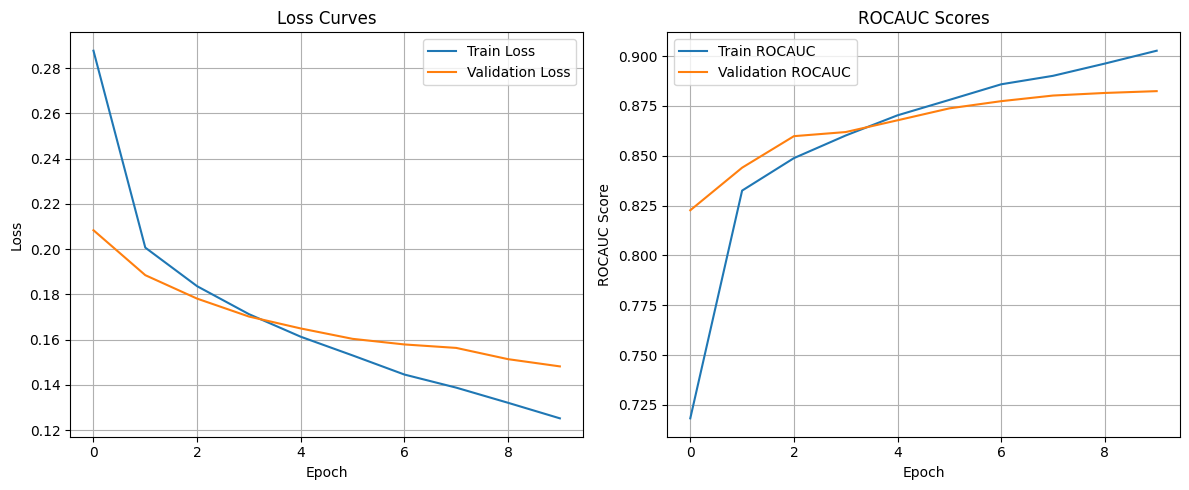

DONE


In [8]:
EPOCHS = 10
LR = 5e-6
WEIGHT_DECAY = 0.01
PATIENCE = 3
BATCH_SIZE = 64
SCORE_NAME = 'ROCAUC'

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device=}")

model = PaperClassifierV1(n_classes=dataset.n_classes)
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.BCEWithLogitsLoss()

train_losses = []
val_losses = []
train_scores = []
val_scores = []

best_val_score = -np.inf
patience_counter = 0

plt.figure(figsize=(12, 5))

for epoch in range(EPOCHS):
    train_epoch(model, train_loader, device, optimizer, loss_fn, train_losses, train_scores)
    val_epoch(model, val_loader, device, loss_fn, val_losses, val_scores)
    update_plots(train_losses, train_scores, val_losses, val_scores, SCORE_NAME)

    if val_scores[-1] > best_val_score:
        best_val_score = val_scores[-1]
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1

    if patience_counter == PATIENCE:
        print("Early stopping")
        break

print("DONE")

In [27]:
model.load_state_dict(torch.load('best_model.pt'))

x = dataset._tokenizer("TabReD: Analyzing Pitfalls and Filling the Gaps in Tabular Deep Learning Benchmarks", return_tensors='pt')
x['input_ids'] = x['input_ids'].to(device)
x['attention_mask'] = x['attention_mask'].to(device)

model(**x)

tensor([[ 3.0340, -4.7782, -3.8237, -4.2518, -4.8341, -2.8256, -4.7077, -4.2145]],
       device='cuda:0', grad_fn=<AddmmBackward0>)